# Evaluating Models
## 1. Introduction
In this notebook, we do a very basic evaluation of each model against a manually generated dataset.
We will compare:
- BinaryNet
- XNOR-NET
- ABCNet

## 2. Generating Data
### 2.1 Function
We will choose a quadratic function:
$$
  F(x)=ax^2+bx+c
$$
### 2.2 Parameters
We will set:
- $a=2$
- $b=3$
- $c=2$

### 2.3 Data
1. We will generate $n=20000$ samples $X_1,\dots,X_n$ from the uniform distribution $\mathcal{U}(-4,4)$
2. We will generate $n=20000$ samples $\epsilon_1,\dots,\epsilon_n$ from the normal distribution $\mathcal{N}(0,\sigma),$ with $\sigma=0.1$
3. We will calculate $y_1,\dots,y_n$ as:
    $$
    y_i=aX_i^2+bX_i+c+\epsilon_i
    $$

In [55]:
import tensorflow as tf
import larq as lq
import layers
import numpy as np
import quantizers
from sklearn.model_selection import train_test_split

a=2
b=3
c=2
n=20000
std=0.1
X=np.random.uniform(-4,4,[n,1])
err=np.random.normal(0,std,[n,1])
y=a*X**2+b*X+c+err

## 3. Creating Models

In [56]:
binarynet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

xnornet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

abcnet_args = dict(
    kernel_estimators=5,
    kernel_quantizers=quantizers.ShiftedSteSign,
    input_quantizers=quantizers.ShiftedSteSign,
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

X_train,X_test,y_train,y_test=train_test_split(X,y)


models={}
noisy_models={}
model_names=["BinaryNet","XNOR-NET","ABCNet"]
model_layers={"BinaryNet":lq.layers.QuantDense,"XNOR-NET":layers.ScaledQuantDense,"ABCNet":layers.ABCDense}

for name,kwargs in zip(model_names,[binarynet_args,xnornet_args,abcnet_args]):
    Dense=model_layers[name]
    layers=[tf.keras.layers.Dense(24),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(1, **kwargs)]
    models[name]=tf.keras.models.Sequential(layers)
    noisy_models[name]=tf.keras.models.Sequential([
        tf.keras.layers.GaussianNoise(stddev=.5),
        *layers
    ])

## 4. Fitting Models

In [58]:
for model_family in [models,noisy_models]:
    for model in model_family.values():
        model.compile(
            tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
            loss="mean_squared_error"
        )
        model.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=30,
            validation_data=(X_test, y_test),
            shuffle=True
        )

Epoch 1/30
118/118 [==============================] - 1s 4ms/step - loss: 40.7549 - val_loss: 61.2301
Epoch 2/30
118/118 [==============================] - 0s 4ms/step - loss: 34.6274 - val_loss: 54.8944
Epoch 3/30
118/118 [==============================] - 0s 3ms/step - loss: 34.6016 - val_loss: 55.7147
Epoch 4/30
118/118 [==============================] - 0s 3ms/step - loss: 34.9662 - val_loss: 50.8129
Epoch 5/30
118/118 [==============================] - 0s 3ms/step - loss: 35.0289 - val_loss: 46.9813
Epoch 6/30
118/118 [==============================] - 0s 3ms/step - loss: 34.0802 - val_loss: 45.7710
Epoch 7/30
118/118 [==============================] - 0s 3ms/step - loss: 33.4887 - val_loss: 46.9586
Epoch 8/30
118/118 [==============================] - 0s 3ms/step - loss: 33.0648 - val_loss: 33.8376
Epoch 9/30
118/118 [==============================] - 0s 4ms/step - loss: 33.3731 - val_loss: 34.3660
Epoch 10/30
118/118 [==============================] - 0s 3ms/step - loss: 34.4518

## 5. Plotting Boundaries

32/32 [==============================] - 0s 2ms/step


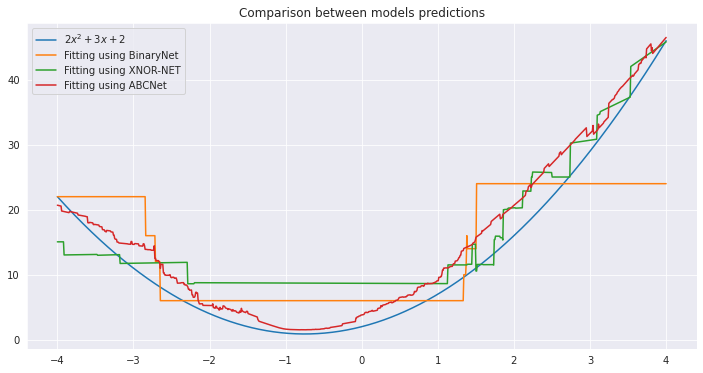

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(1,1,figsize=(12,6))
def plot_models(X,models,ax=None):
    if ax is None:
        fig,ax=plt.subplots(1,1)
    sns.lineplot(x=U,y=a*U**2+b*U+c,ax=ax,label=f"${a}x^2+{b}x+{c}$")
    for name in models:
        sns.lineplot(x=U,y=models[name].predict(U.reshape((-1,1))).reshape((-1,)),ax=ax,label=f"Fitting using {name}")

m=1000
U=np.linspace(-4,4,m)
plot_models(U,models,ax)
ax.set_title("Comparison between models predictions")
fig.savefig("local/model-performances-quadratic.svg")

32/32 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Comparison between models predictions with additional gaussian layer')

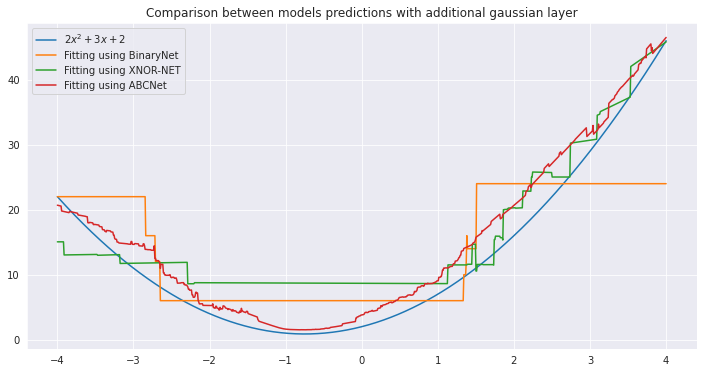

In [60]:
fig2,ax2=plt.subplots(1,1,figsize=(12,6))
plot_models(U,noisy_models,ax2)
ax2.set_title("Comparison between models predictions with additional gaussian layer")